In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os
import igraph
from collections import Counter
import networkx as nx

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics
import seaborn as sns
from helpers.networks import *
import helpers.linkage as lkg
import helpers.style as style
import scipy.sparse as spar
import datetime

import warnings
warnings.filterwarnings("ignore")

from networkx.algorithms.community import quality
from networkx.algorithms.assortativity import average_degree_connectivity,average_neighbor_degree
import networkx.algorithms.community as nx_comm
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

style.load_style()

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
data = dataloader.load(cf,agg_level='speech',model_type='lda',num_topics=100)
dists = data['dists']
labels = data['labels']
data = data['data']

In [45]:
d_arrays = {pd.Timestamp(year=y,month=1 if h == 0 else 6,day=1):_.to_numpy() for (y,h),_ in dists.groupby([dists.index.year,(dists.index.month-1)//6]) if len(_) > 10}
stats, mi_arrays = diachronic_linkage(d_arrays)

100%|██████████| 42/42 [00:01<00:00, 21.64it/s]


# Network (Community) Statistics with Different _Weight Filter_ Thresholds

In [46]:
diag = []
for c,(d,mi) in tqdm(enumerate(mi_arrays.items())):
    for wf in np.arange(0,3,.5): #
        g,comm,df = get_network_from_mi_theta(mi_theta=mi,weighted=False,cluster_method='louvain',weight_threshold=wf)
        if len(df) == 0:
            continue
        g_nx = g.to_networkx()
        g_nx_comm = nx_comm.louvain_communities(g_nx)
        pq = quality.partition_quality(G=g_nx,partition=g_nx_comm)
        mod = quality.modularity(G=g_nx,communities=g_nx_comm)
        diag.append({"date":d,"performance":pq[0],"coverage":pq[1],"modularity":mod,"wf":round(wf,2)})
diag = pd.DataFrame(diag)

42it [00:04,  9.10it/s]


In [48]:
diagz = []
for i,dat in diag.groupby(['wf']):
    for m in ['performance','coverage','modularity']:
        dat[m] = zscore(dat[m])
    diagz.append(dat)
diagz = pd.concat(diagz)
# diagz = diagz.groupby([diagz.date.dt.to_period('Y'),diagz.wf]).mean().reset_index()
# diagz['date'] = diagz.date.dt.to_timestamp()

In [49]:
diagz

,date,performance,coverage,modularity,wf
0,1946-01-01,1.290701,0.267308,0.293848,0.0
6,1946-06-01,0.294192,-0.665802,-0.647383,0.0
12,1947-01-01,0.310782,-0.576935,0.319314,0.0
18,1947-06-01,0.785988,-1.821082,-1.143343,0.0
24,1948-01-01,-0.683511,1.067117,0.231158,0.0
...,...,...,...,...,...
227,1964-06-01,-1.464627,-0.772160,-4.214711,2.5
233,1965-01-01,0.459845,-0.512815,0.315869,2.5
239,1965-06-01,1.181521,0.979251,-0.435632,2.5
245,1966-01-01,1.181521,-1.072402,-0.359840,2.5


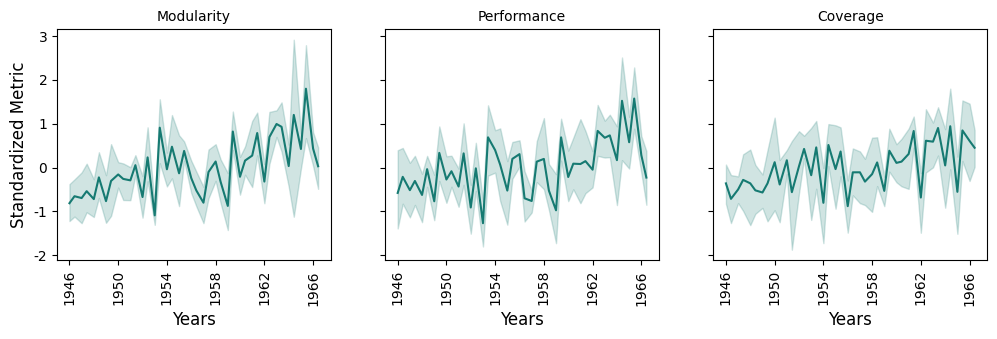

In [50]:
fig,ax = plt.subplots(1,3,figsize=(12,3),sharey=True)

for c,metric in enumerate(['modularity','performance','coverage']):
    sns.lineplot(data=diagz,x='date',y=metric,ax=ax.flatten()[c],color=sns.color_palette('BrBG')[-1])
    ax.flatten()[c].set_title(metric.capitalize())
    ax.flatten()[c].set_xticklabels(ax.flatten()[c].get_xticklabels(),rotation=90)
    ax.flatten()[c].set_ylabel('Standardized Metric')
    ax.flatten()[c].set_xlabel('Years')

    years = YearLocator()
    yearsFmt = DateFormatter('%Y')
    ax.flatten()[c] = plt.gca()
    ax.flatten()[c].xaxis.set_major_locator(years)
    ax.flatten()[c].xaxis.set_major_formatter(yearsFmt)
    ax.flatten()[c].autoscale_view()
    ax.flatten()[c].set_xticks([datetime.date(y,1,1) for y in range(1946,1967,4)])

# plt.savefig('figs/network-metrics-bootstrapped-weight-filter.pdf',dpi=250)
plt.show()

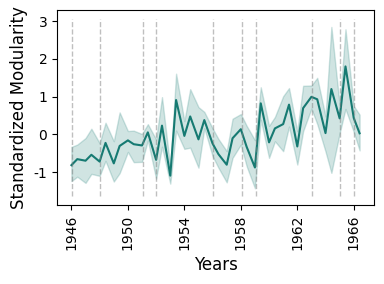

In [52]:
fig,ax = plt.subplots(1,1,figsize=(4,3),sharey=True)

sns.lineplot(data=diagz,x='date',y='modularity',ax=ax,color=sns.color_palette('BrBG')[-1])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel('Standardized Modularity')
ax.set_xlabel('Years')

years = YearLocator()
yearsFmt = DateFormatter('%Y')
ax = plt.gca()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.autoscale_view()
ax.set_xticks([datetime.date(y,1,1) for y in range(1946,1967,4)])
add_cabinet_periods(ax,text=False,color='grey',max_time=1966)

fig.tight_layout()
plt.savefig('figs/network-modularity-bootstrapped-weight-filter.pdf',dpi=250,bbox_inches='tight')
plt.show()